## t-SNE visualisation of Covid_trained model activations



In [1]:
import tensorflow as tf
from tensorflow.keras import Model
import numpy as np
from collections import Counter
import pandas as pd
import os

In [2]:
# data from https://github.com/zeeshannisar/COVID-19/blob/master/Implementations/dataset%2002/DenseNet169-Transfer%20Learning-COVID19-dataset%2002.ipynb
dataDir = 'covid_data'
train_x = np.load(dataDir+'/train_images.npy')
train_y = np.load(dataDir+'/train_labels.npy')
test_x = np.load(dataDir+'/test_images.npy')
test_y = np.load(dataDir+'/test_labels.npy')

print('Training Images: {} | Test Images: {}'.format(train_x.shape, test_x.shape))
print('Training Labels: {} | Test Labels: {}'.format(train_y.shape, test_y.shape))

# Data Normalization

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

train_x/=255.0
test_x/=255.0

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

Training Images: (14925, 224, 224, 3) | Test Images: (231, 224, 224, 3)
Training Labels: (14925,) | Test Labels: (231,)
Train: 0.0 , 255.0 | Test: 0.0 , 255.0
Train: 0.0 , 1.0 | Test: 0.0 , 1.0


In [3]:
# Class Mapping 
print('0:Normal | 1:Pneumonia | 2:COVID-19')

# Distribution of images in each class for Training-set
print(Counter(train_y))

# Distribution of images in each class for Test-set
print(Counter(test_y))

#Make Labels Categorical
train_y_oneHot = tf.one_hot(train_y, depth=3) 
test_y_oneHot = tf.one_hot(test_y, depth=3)

print('Training Labels: {} | Test Labels: {}'.format(train_y_oneHot.shape, test_y_oneHot.shape))

0:Normal | 1:Pneumonia | 2:COVID-19
Counter({0: 8751, 1: 5945, 2: 229})
Counter({0: 100, 1: 100, 2: 31})
Training Labels: (14925, 3) | Test Labels: (231, 3)


In [4]:
print(test_y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]


In [5]:
# y_hat = model.predict(test_x, verbose=1)
# y = test_ds.get_y_true()
# model_path = "covid_data/denseNet121best-model_without_dropout.h5" # 0.81 0.91 0.6281
# model_path = 'covid_data/denseNet121-model.h5' # 0.82, 0.94, 0.5922
# model_path = "covid_data\denseNet121best-model.h5" # 0.82 0.82 0.6464
# model_path = "covid_data\denseNet121-original-model_without_dropout.h5" # 0.88 0.97 0.3393

# model_path = "covid_data/denseNet121_transfer_model_with_dropout.h5" # 0.81 0.95 0.5118
# model_path = "covid_data\denseNet121-original.h5" # 0.88 , 0.98, 0.3137

model_path = "covid_data/Training/bestmodel_class_weight_unfreeze_version2.h5" #91.34
model = tf.keras.models.load_model(model_path)

In [6]:
my_dict = {
    'image_name': [],
    'ground_truth': [],
    'predicted': [],
    'softmax_vals_normal': [],
    'softmax_vals_pneumonia': [],
    'softmax_vals_covid': []
}

for i in range(231):
    my_dict['image_name'].append(i)
    my_dict['ground_truth'].append(test_y[i])

    img = test_x[i]
    img = np.expand_dims(img, axis = 0)
    y_hat = model.predict(img)
    
    softmax = y_hat[0]
    my_dict['predicted'].append(np.argmax(y_hat))
    my_dict['softmax_vals_normal'].append(softmax[0])
    my_dict['softmax_vals_pneumonia'].append(softmax[1])
    my_dict['softmax_vals_covid'].append(softmax[2])


df = pd.DataFrame(my_dict)
df.tail()

,image_name,ground_truth,predicted,softmax_vals_normal,softmax_vals_pneumonia,softmax_vals_covid
226,226,2,2,0.000062,0.021471,0.978468
227,227,2,2,0.000584,0.162792,0.836624
228,228,2,2,0.000721,0.028451,0.970828
229,229,2,1,0.001578,0.983183,0.015239
230,230,2,2,0.051764,0.033833,0.914402


In [7]:
df['softmax_vals_normal'] = df['softmax_vals_normal'].astype(float)
df['softmax_vals_pneumonia'] = df['softmax_vals_pneumonia'].astype(float)
df['softmax_vals_covid'] = df['softmax_vals_covid'].astype(float)

In [8]:
lr = 0.001
momentum = 0.9
nestrov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum,nesterov=nestrov)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
loss, accuracy, auc = model.evaluate(x=test_x, y=test_y_oneHot, batch_size=32, verbose=1)

8/8 [==============================] - 60s 6s/step - loss: 0.2390 - categorical_accuracy: 0.9134 - auc: 0.9845


In [10]:
layer_outputs = model.layers[424].output # last concate layer
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [11]:
all_firings = []
img = test_x[0]
img = np.expand_dims(img, axis = 0)
activations = activation_model.predict(img)
all_firings = activations

for i in range(1,231):
    img = test_x[i]
    img = np.expand_dims(img, axis = 0)

    activations = activation_model.predict(img)
    all_firings = np.concatenate((all_firings,activations))
# np.savetxt('firings.csv', all_firings, delimiter=',')

In [12]:
all_firings.shape

(231, 7, 7, 1024)

In [76]:
# firings = np.loadtxt('firings.csv',delimiter=',')

In [84]:
# print(firings.shape)
# a_ssx  = firings.reshape(5,7,7,1024)

(5, 50176)
(5, 7, 7, 1024)
[[[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  ...

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  

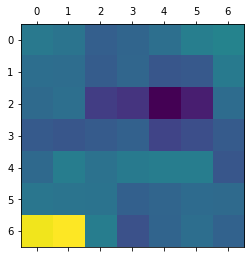

In [13]:
import matplotlib.pyplot as plt
plt.matshow(activations[0, :, :, 6])

In [14]:
# Vectorise the data into nExamples x nDims [7x7x1024 = 50,176 dims]
activations = np.reshape(all_firings, (231, 50176))

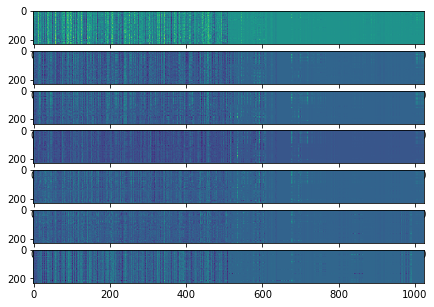

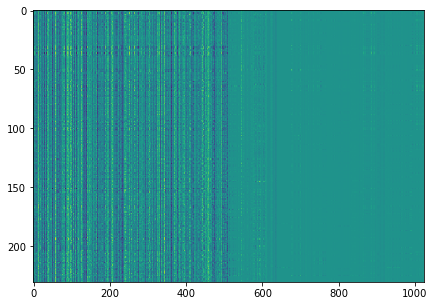

In [15]:
# Plot all the activations (vectorised)
fig,ax = plt.subplots(7,figsize=(7,5))
for i in range(7):
    ax[i].imshow(all_firings[:,i,i,:], interpolation='nearest', aspect='auto')

fig,ax = plt.subplots(figsize=(7,5))
ax.imshow(all_firings[:,0,0,:], interpolation='nearest', aspect='auto')

In [63]:
from sklearn.decomposition import PCA
pca = PCA(.99)
activations_pca = pca.fit_transform(activations)
print(activations_pca.shape)

(231, 204)


In [71]:
# Project from feature space into a 2D distribution (‘X_embedded’)
from sklearn.manifold import TSNE
model = TSNE(n_components=2, init='pca')
# X_embedded = model.fit_transform(activations_pca)
# print(activations.shape)
X_embedded = model.fit_transform(activations)

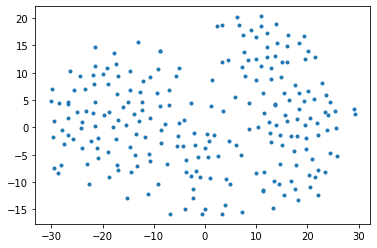

In [72]:
# Plot the distribution
fig,ax = plt.subplots()
ax.plot(X_embedded[:,0], X_embedded[:,1], '.')

In [73]:
# Add the embedding to the dataframe
df['x_val'] = X_embedded[:,0]
df['y_val'] = X_embedded[:,1]

In [74]:
# Code for viewing plots in different colours based on the metadata

import struct #for coloring
# map colors
def clamp(x):
    return max(0, min(x, 255))

def set_colors(vals_for_color):
    #print(vals_for_color)
    min_val = min(vals_for_color); max_val = max(vals_for_color)
    vals_for_color_norm = [(float(val) - min_val) / (max_val - min_val) for val in vals_for_color] #between 0 and 1
    vals_for_color_norm = [val if val<1 else 0.9999 for val in vals_for_color_norm]
    #print(vals_for_color_norm)
    colors_unit = [plt.cm.seismic(val)[:3] for val in vals_for_color_norm]
    #print(colors_unit)
    colors_rgb = [(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in colors_unit]
    #print(colors_rgb)
    colors_hex = ["#{0:02x}{1:02x}{2:02x}".format(clamp(color_rgb[0]), clamp(color_rgb[1]), clamp(color_rgb[2])) for color_rgb in colors_rgb]
    
    #colors_hex = ['#' + struct.pack('BBB',*color_rgb).encode('hex') for color_rgb in colors_rgb]
    return colors_hex

#'ground_truth', 'predicted', 'softmax_vals_normal', 'softmax_vals_pneumonia', 'softmax_vals_covid'
for col in ['ground_truth', 'predicted', 'softmax_vals_normal', 'softmax_vals_pneumonia', 'softmax_vals_covid']: #df.columns
    print('color_'+col)
    #print(df[col].values)
    my_col_string = 'color_'+col
    df[my_col_string] = set_colors(df[col].values)

# Set default colour
df['color_data'] = set_colors(df['ground_truth'])


color_ground_truth
color_predicted
color_softmax_vals_normal
color_softmax_vals_pneumonia
color_softmax_vals_covid


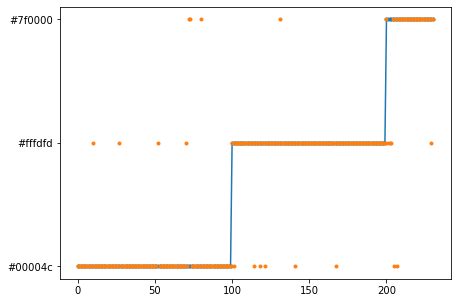

In [75]:
# Compare ground truth to predicted. Currently using 'color' as a proxy for an int representing the class
fig,ax = plt.subplots(figsize=(7,5))
ax.plot(df['color_ground_truth'], '.-')
ax.plot(df['color_predicted'], '.')

In [60]:
df.columns

Index(['image_name', 'ground_truth', 'predicted', 'softmax_vals_normal',
       'softmax_vals_pneumonia', 'softmax_vals_covid', 'x_val', 'y_val',
       'color_ground_truth', 'color_predicted', 'color_softmax_vals_normal',
       'color_softmax_vals_pneumonia', 'color_softmax_vals_covid',
       'color_data', 'filepaths', 'base_filepaths'],
      dtype='object')

In [61]:
import glob

data_range = len(test_y)
images = "./covid_data/test_images/"
img_fns = glob.glob(images + "/*.png")

import re

# natural key sorting for the images
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_key(img_fns):
    return [ atoi(c) for c in re.split(r'(\d+)', img_fns) ]

img_fns.sort(key = natural_key)

In [52]:
df['filepaths'] = img_fns[0:data_range]

base_filepaths = [os.path.basename(fn) for fn in img_fns[0:data_range]]
df['base_filepaths'] = base_filepaths

In [76]:
# Create bokeh plot
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import Button, HoverTool, PanTool, WheelZoomTool
from bokeh.models.callbacks import CustomJS
from bokeh.events import ButtonClick
#from bokeh.models.widgets import Button
from bokeh.layouts import widgetbox, gridplot, column, row

output_file("./bokeh_vis_features.html")
figure_size=500

# Change colour here:
#df['color_data'] = set_colors(df.predicted)

source = ColumnDataSource(data=df.to_dict('list'))
source2 = ColumnDataSource(data=df.to_dict('list'))
    
#HTML for displaying the video on hover
hover = HoverTool(
    tooltips="""
        <div>
            <span style="font-size: 14px;">@image_name</span>
            <br>
            <span style="font-size: 10px;">GT: @ground_truth</span>
            <br>
            <span style="font-size: 10px;">Pred: @predicted</span>
        </div>
        <div>
            <img
                src="@filepaths" alt="@base_filepaths" height="200" width="200"
                style="float: center;"
                border="2"
            ></img>
        </div>
        """
)

#<span style="font-size: 10px;">filepath: @filepaths</span>

#set up the plot  
p = figure(tools=[hover, PanTool(), WheelZoomTool()], #WheelZoomTool()
            plot_width=figure_size+500, plot_height=figure_size,
            toolbar_location="above", title="COVID analysis")

#draw the scatter plot
p.circle('x_val', 'y_val', fill_color='color_data', source=source, line_color='black', size=10, alpha=0.7)

from bokeh.models import LinearAxis
p.xaxis.visible = None
p.yaxis.visible = None
xaxis = LinearAxis(axis_label= "X-embedding")
yaxis = LinearAxis(axis_label= "Y-embedding")
p.add_layout(xaxis, 'below')
p.add_layout(yaxis, 'left')
p.background_fill_color = "#dddddd"

# The callback to change the colour of the dots based on which button is pressed
callback = CustomJS(args=dict(source=source, source2=source2), code="""
    var data = source.data;
    var data2 = source2.data;
    data['color_data'] = data2[cb_obj.origin.name];
    source.change.emit();
""")
#console.log(cb_obj);

# Set up buttons to change the colour of the dots
#'ground_truth', 'predicted', 'softmax_vals_normal', 'softmax_vals_pneumonia', 'softmax_vals_covid'
button1 = Button(label="ground_truth", name="color_ground_truth")
button2 = Button(label="predicted", name="color_predicted")
button3 = Button(label="softmax_vals_normal", name="color_softmax_vals_normal")
button4 = Button(label="softmax_vals_pneumonia", name="color_softmax_vals_pneumonia")
button5 = Button(label="softmax_vals_covid", name="color_softmax_vals_covid")
# add the callback on button click
button1.js_on_click(callback)
button2.js_on_click(callback)
button3.js_on_click(callback)
button4.js_on_click(callback)
button5.js_on_click(callback)

#output
layout = column(p, row(button1, button2), row(button3, button4, button5))
show(layout)
#show(p)

## Feature Visualisation

In [77]:
model_path = "covid_data/Training/bestmodel_class_weight_unfreeze_version2.h5" #91.34
model = tf.keras.models.load_model(model_path)

In [78]:
lr = 0.001
momentum = 0.9
nestrov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum,nesterov=nestrov)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
loss, accuracy, auc = model.evaluate(x=test_x, y=test_y_oneHot, batch_size=32, verbose=1)

8/8 [==============================] - 14s 1s/step - loss: 0.2390 - categorical_accuracy: 0.9134 - auc_1: 0.9845


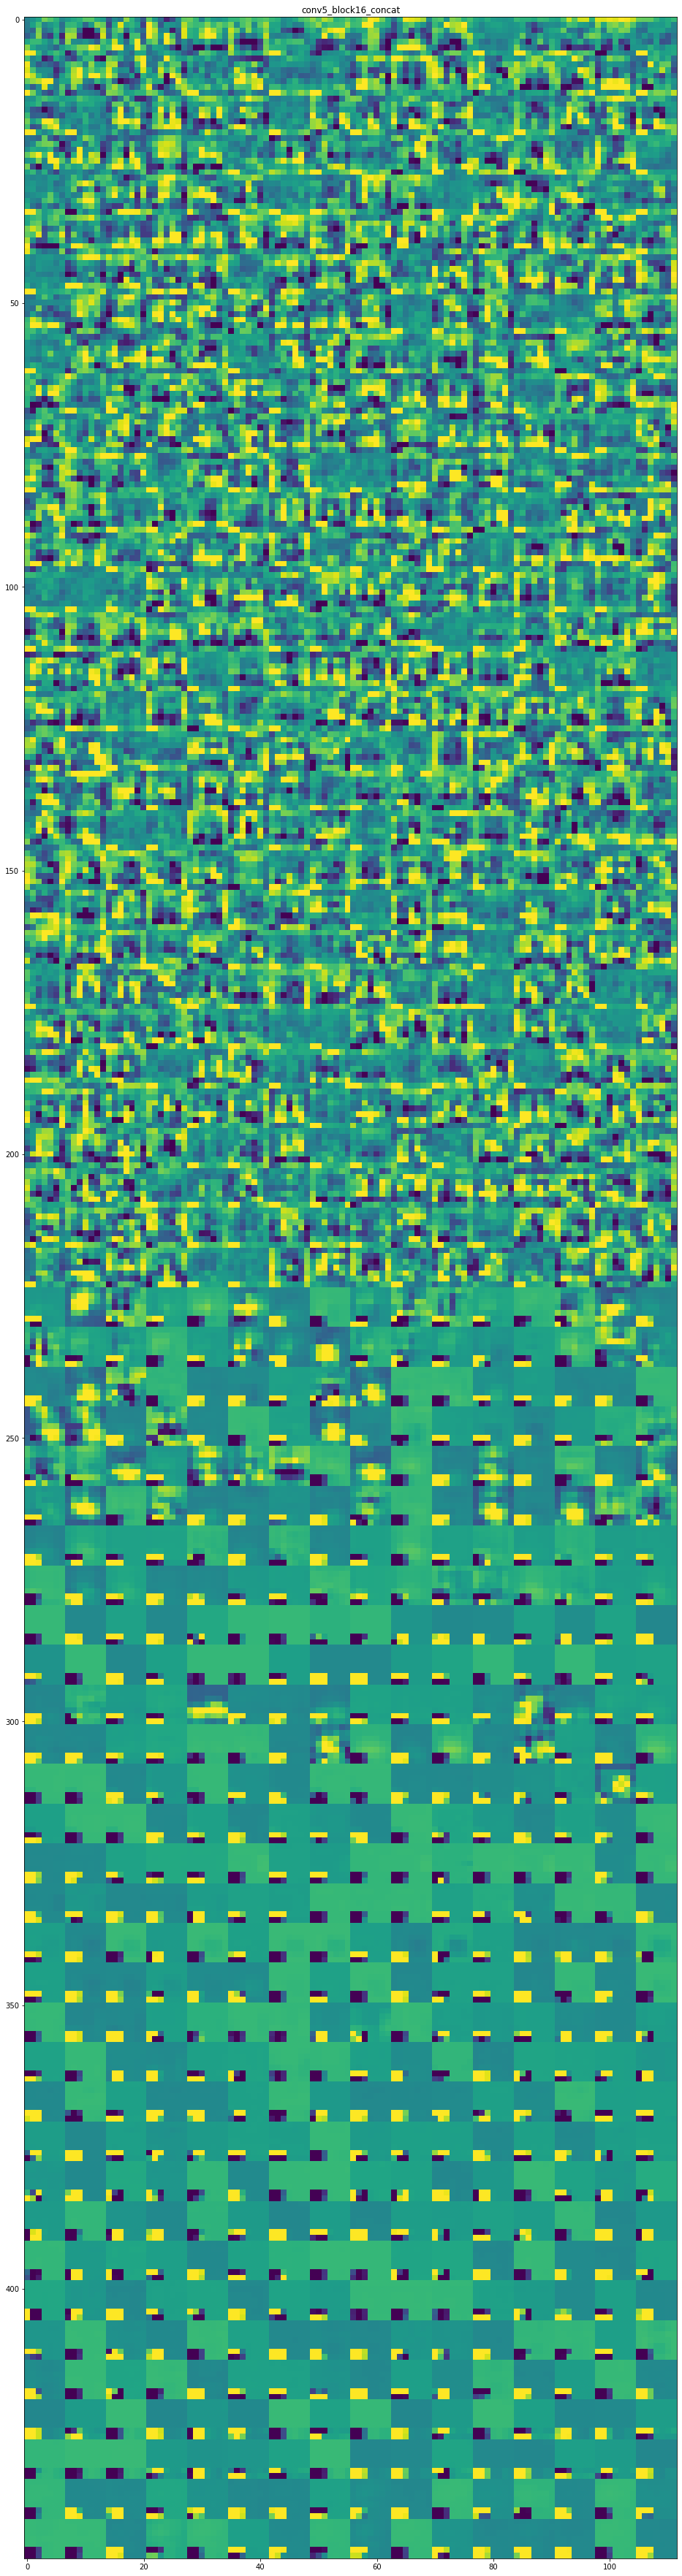

In [81]:
layer_start = 424
layer_end = 425

layer_outputs = [layer.output for layer in model.layers[layer_start:layer_end]] 
# Extracts the outputs of the top 12 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(img)

layer_names = []
for layer in model.layers[layer_start:layer_end]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
# print(layer_names)
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    # print(layer_name, layer_activation.shape)
    images_per_row = 16
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    layer_activation = np.expand_dims(layer_activation, axis = 0) 
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    # print(layer_activation.shape)
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    
    if n_cols == 0 :
        images_per_row = n_features
        n_cols = 1
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 224).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
            # print(n_features, n_cols, images_per_row)
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto')
